Lets start by loading required packages and reading from the data file!

In [1]:
import csv
import cv2
import numpy as np 
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

%matplotlib inline

# 1 radian to degree
radian_to_degree = 57.3

lines = []
with open('data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)


Lets read the steering angles and plot histogram of the given data (corresponding to track 1) assuming only center images.

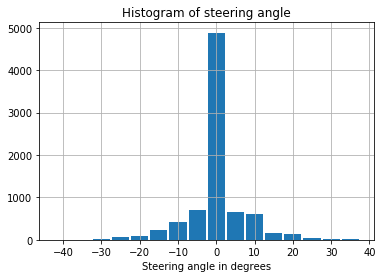

In [2]:
steering_angles = []
# Only load the images given with the project
for line in lines[1:8038]:
    # steering angles in degrees
    measurement = radian_to_degree*float(line[3])
    steering_angles.append(measurement)

steering_angles = np.array(steering_angles)
plt.hist(steering_angles, bins = np.arange(-42.5, 42.5, 5), rwidth = 0.9, align = 'mid')
plt.title("Histogram of steering angle")
plt.xlabel('Steering angle in degrees')
plt.grid(True)
plt.show()


Clearly the data is biased and ~0 steering angles dominate. Also because the track has more left turns, negative angles are better represented than positive angles. Let us include the left and right images and add 0.25 and -0.25 corrections (in radians) respectively. Additionally, lets flip the images and the corresponding steering angles and add them to the dataset. 

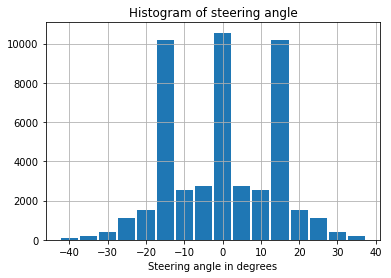

In [3]:
steering_angles = []
# converting radians to degrees
correction = radian_to_degree*np.array([0, 0.25, -0.25])
for line in lines[1:8038]:
    for i in range(3):
        # steering angle in degrees
        measurement = radian_to_degree*float(line[3]) + correction[i]
        steering_angles.append(measurement)
        steering_angles.append(-1*steering_angles[-1])
        
steering_angles = np.array(steering_angles)
plt.hist(steering_angles, bins = np.arange(-42.5, 42.5, 5), rwidth = 0.9, align = 'mid')
plt.title("Histogram of steering angle")
plt.xlabel('Steering angle in degrees')
plt.grid(True)
plt.show()

Better -  but still if the model is trained on this dataset, it would tend to learn the three steering angles - -0.25, 0 and 0.25. The car being driven by a neural network learning these values may veer from side to side and won't be driving as smooth as humans. To fix it, consider horizontal translations to balance the dataset. Note that I also consider other image augmentation techniques (for e.g., brightness augmentation & adding shadow to images) for generalization, but these don't affect the steering angles and thus are not presented here.

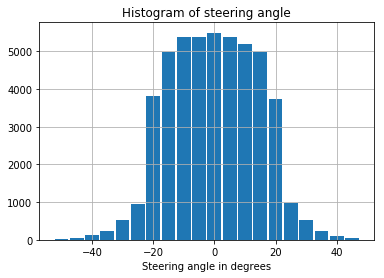

In [6]:
# image processing
def translate_image(angle, translate_range_hor):
    dx = np.random.randint(-translate_range_hor//2, translate_range_hor//2)
    angle = angle + dx * 0.0025 * radian_to_degree
    return angle

def perturb_image_helper(angle):
    translate_range_hor = 100 # translate range in pixels
    angle = translate_image(angle, translate_range_hor)
    return angle

steering_angles = []
# converting radians to degrees
correction = radian_to_degree*np.array([0, 0.25, -0.25])
for line in lines[1:8038]:
    for i in range(3):
        # steering angle in degrees
        measurement = radian_to_degree*float(line[3]) + correction[i]
        steering_angles.append(perturb_image_helper(measurement))
        steering_angles.append(perturb_image_helper(-1.0*measurement))
        
steering_angles = np.array(steering_angles)
plt.hist(steering_angles, bins = np.arange(-52.5, 52.5, 5), rwidth = 0.9, align = 'mid')
plt.title("Histogram of steering angle")
plt.xlabel('Steering angle in degrees')
plt.grid(True)
plt.show()

Now the histogram has a nice Gaussian representation with 0 mean.

Lets visualize the original image and all image augmentations next. The image goes through the following image processing : original image => random brightness => random shadow => horizontal and vertical translation.
Note that only horizontal translation causes steering angle change

Text(0.5,1,'steering angle = -0.05530863')

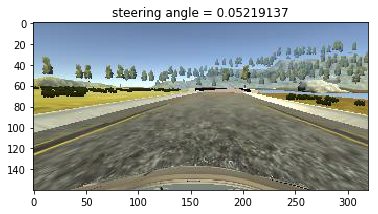

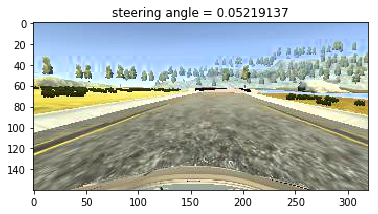

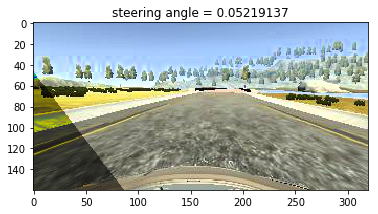

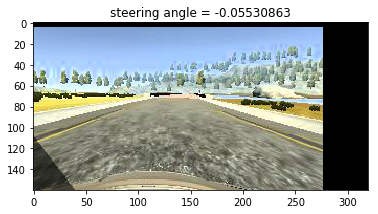

In [40]:
def brightness_augment_image(image):
    """
    Scales the brightness uniformly randomly 
    :param image: RGB image
    :return: RGB image randomly scaled brightness
    """

    # convert to HSV and scale last dimension randomly
    image = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    image = np.array(image, dtype = np.float64)
    random_brightness = .5+np.random.uniform()
    image[:,:,2] = image[:,:,2]*random_brightness
    image[:,:,2][image[:,:,2]>255]  = 255
    image = np.array(image, dtype = np.uint8)
    # convert back to RGB
    image = cv2.cvtColor(image,cv2.COLOR_HSV2RGB)
    return image

def translate_image(image, angle, translate_range_hor, translate_range_ver):

    """
    Translates the image horizontally and vertically
    :param image: RGB image
    :param angle: steering angle associated with input image
    :param translate_range_hor: max translation in horizontal direction
    :param translate_range_ver: max translation in vertical direction
    :return: RGB image translated horizontally and vertically
    """
    dx = np.random.randint(-translate_range_hor//2, translate_range_hor//2)
    dy = np.random.randint(-translate_range_ver//2, translate_range_ver//2)
    transform_matrix = np.float32([[1,0,dx],[0,1,dy]])
    image = cv2.warpAffine(image,transform_matrix,(image.shape[1], image.shape[0]))
    angle = angle + dx * 0.0025
    return image,angle

def random_shadow(image):
    """
    Adds random shadow to image
    :param image: RGB image
    :return: RGB image with random shadow
    """
    x1, y1 =  np.random.randint(0, image.shape[1]), 0
    x2, y2 = np.random.randint(0, image.shape[1]), image.shape[0] 
    
    xn, yn = np.mgrid[0:image.shape[0] , 0:image.shape[1] ]
    
    mask = np.zeros_like(image[:, :, 1])
    mask[(yn - y1) * (x2 - x1) - (y2 - y1) * (xn - x1) > 0] = 1

    cond = mask == np.random.randint(0, 2)
    random_brightness = np.random.uniform(low=0.2, high=0.5)

    image_hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    image_hls[:, :, 1][cond] = image_hls[:, :, 1][cond] * random_brightness
    return cv2.cvtColor(image_hls, cv2.COLOR_HLS2RGB)


translate_range_hor = 100
translate_range_ver = 20
# loading a random image to show image processing
index = np.random.randint(low = 1,high = 1000)
source_path = lines[index][0]
filename = source_path.split('/')[-1]
current_path = 'data/IMG/' + filename
image = mpimg.imread(current_path)
measurement = float(lines[index][3])
plt.figure(1)
plt.imshow(image)
plt.title("steering angle = " + str(measurement))
image = brightness_augment_image(image)
plt.figure(2)
plt.imshow(image)
plt.title("steering angle = " + str(measurement))
image = random_shadow(image)
plt.figure(3)
plt.imshow(image)
plt.title("steering angle = " + str(measurement))
image, measurement = translate_image(image, measurement, translate_range_hor, translate_range_ver)
plt.figure(4)
plt.imshow(image)
plt.title("steering angle = " + str(measurement))
